# 用神经网络估计Q值的Sarsa

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
print(gym.__version__)   #1.1.1

1.1.1


In [4]:
env_name = 'CartPole-v1'
env = gym.make(env_name)
device = torch.device("cuda:0")

In [5]:
state, info = env.reset()
action = env.action_space.sample()
print(action,type(action),action.ndim,action.shape)

0 <class 'numpy.int64'> 0 ()


In [6]:
env.step(1)

(array([ 0.00886425,  0.15365633,  0.03926547, -0.2394362 ], dtype=float32),
 1.0,
 False,
 False,
 {})

# Q网络

In [7]:
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, state):
        return self.net(state)
    #输入一个一维np.array,(4,)，输出一个一维的np.array,(2,)表示2个动作的Q值

# SarsaNN

In [8]:
class SarsaNN:
    def __init__(self, state_dim, action_dim, epsilon, lr, gamma,device):
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma
        self.device = device

        self.q_net = QNet(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)  #这里输出的不是np.array,而是int
        else:
            state = torch.tensor(np.array(state), dtype=torch.float).to(self.device)
            with torch.no_grad():
                action = self.q_net(state).argmax().item()     #输入state给q_net,获得q
        return action  # 输出的action是一个标量，一个整数int

    def update(self, s, a, r, s_next, a_next, done):
        # 输入的s是一维np.array
        s = torch.tensor(s, dtype=torch.float32).to(self.device).view(1, -1)       # shape [1, state_dim]
        s_next = torch.tensor(s_next, dtype=torch.float32).to(self.device).view(1, -1)  # shape [1, state_dim]

        r = torch.tensor(r, dtype=torch.float32, device=self.device)
        done = torch.tensor(done, dtype=torch.float32, device=self.device)

        q_sa = self.q_net(s)[0, a]

        with torch.no_grad():
            q_next = self.q_net(s_next)[0, a_next]
            target = r + self.gamma * q_next * (1 - done)

        loss = F.mse_loss(q_sa, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# 训练

## 训练函数

In [9]:
def train_sarsa_nn(env, agent, num_episodes=500):
    episode_returns = []

    for episode in range(num_episodes):
        state, _ = env.reset()  # state是一维np.array,(4,)
        episode_return = 0.0

        action = agent.take_action(state)  # 得到的action是个标量
        while True:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_return += reward

            next_action = agent.take_action(next_state)  # Sarsa要获取下一个状态的动作（on-policy）

            agent.update(s=state,a=action,r=reward,s_next=next_state,a_next=next_action,done=done)  # 更新

            state = next_state
            action = next_action

            if done == True:
                break

        episode_returns.append(episode_return)

        if (episode + 1) % 100 == 0:
            avg_return = np.mean(episode_returns[-10:])
            print(f"Episode {episode+1:4d} | "f"Return: {episode_return:7.2f} | "f"Avg(10): {avg_return:7.2f}")

    return episode_returns

## 实例化

In [10]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
epsilon=0.1
lr = 0.001
gamma = 0.95
agent = SarsaNN(state_dim, action_dim, epsilon, lr, gamma ,device)

## 开始训练

In [11]:
num_episodes = 1000
episode_returns = train_sarsa_nn(env, agent, num_episodes)

Episode  100 | Return:   11.00 | Avg(10):   10.30
Episode  200 | Return:   20.00 | Avg(10):   16.00
Episode  300 | Return:   14.00 | Avg(10):   12.20
Episode  400 | Return:   48.00 | Avg(10):   31.60
Episode  500 | Return:   42.00 | Avg(10):   43.70
Episode  600 | Return:  158.00 | Avg(10):  219.30
Episode  700 | Return:  152.00 | Avg(10):  151.60
Episode  800 | Return:  100.00 | Avg(10):  147.30
Episode  900 | Return:  353.00 | Avg(10):  257.20
Episode 1000 | Return:  266.00 | Avg(10):  148.10


## 训练结束

### 保存网络

In [12]:
torch.save(agent.q_net.state_dict(), 'SarsaNN_cartpole_q_net.pth')

### 训练过程可视化

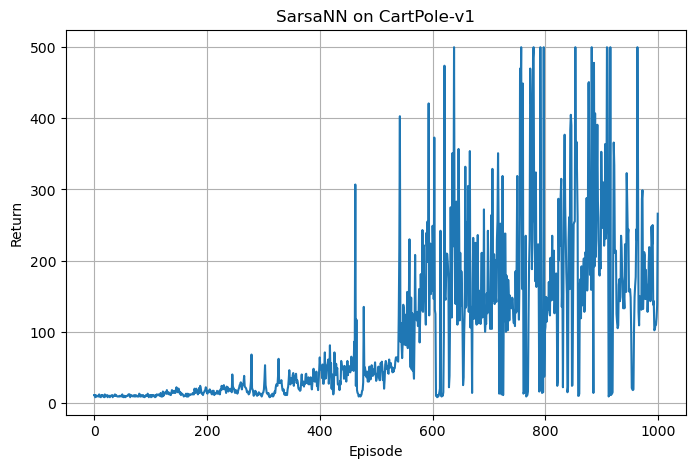

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(episode_returns)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('SarsaNN on CartPole-v1')
plt.grid(True)
plt.show()

可以看出效果不太好，DQN训练300个episode基本都能达到500了，这里训练1000个还是不能稳定接近500